In [1]:
import pandas as pd
import numpy as np
import random
import os
import re
import json
import pickle

import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F

from tqdm import tqdm
import progressbar
import h5py

from matplotlib.pyplot import imshow
from IPython.display import Image as IPyImage
from PIL import Image

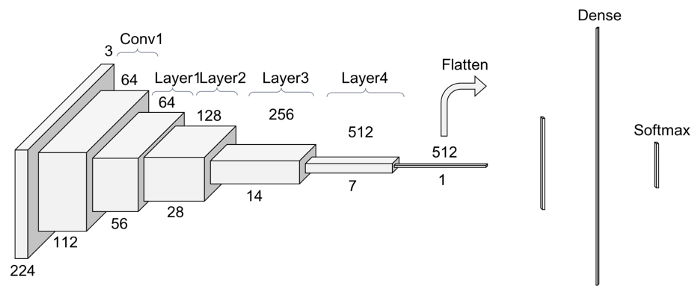

In [27]:
IPyImage('resnet_layers.png')

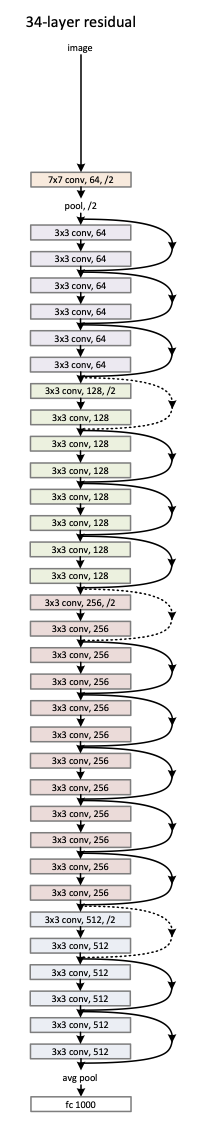

In [5]:
Image('full_resnet.png')

$$(k=3x3,S=2,P=3): (3,224,224)\rightarrow (64,112,112)$$

In [12]:
#BLOCK
class block(nn.Module):
    def __init__(self,in_channels):
        super(block,self).__init__()
        
        self.layer_1=nn.Sequential(
        nn.Conv2d(in_channels=in_channels,out_channels=in_channels,kernel_size=3,stride=1,padding=1,bias=False),
        nn.BatchNorm2d(in_channels),
        nn.ReLU(inplace=True)
        )
        self.layer_2=nn.Sequential(
        nn.Conv2d(in_channels=in_channels,out_channels=in_channels,kernel_size=3,stride=1,padding=1,bias=False),
        nn.BatchNorm2d(in_channels)
        )
        self.relu=nn.ReLU(inplace=True)
        
    def forward(self,x):
        shortcut=x
        out=self.layer_1(x)
        out=self.layer_2(out)
        out+=shortcut
        out=self.relu(out)
        return out

# RESBLOCK
class resblock(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(resblock,self).__init__()
        
        self.layer_1=nn.Sequential(
        nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
        )
        self.layer_2=nn.Sequential(
        nn.Conv2d(in_channels=out_channels,out_channels=out_channels,kernel_size=3,stride=1,padding=1,bias=False),
        nn.BatchNorm2d(out_channels)
        )
        self.shortcut=nn.Sequential(
        nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=1,stride=2,padding=0,bias=False),
        nn.BatchNorm2d(out_channels)
        )
        self.relu=nn.ReLU(inplace=True)
        
    def forward(self,x):
        idt=self.shortcut(x)
        out=self.layer_1(x)
        out=self.layer_2(out)
        out+=idt
        out=self.relu(out)
        return out

#BOTTLENECK
class bottleneck(nn.Module):
    
    def __init__(self,in_channels,width,out_channels,stride):
        super(bottleneck,self).__init__()
        
        self.stack=nn.Sequential(
        nn.Conv2d(in_channels,width,kernel_size=1,stride=stride,padding=0,bias=False),
        nn.BatchNorm2d(width),
        nn.ReLU(width),
        nn.Conv2d(width,width,kernel_size=3,stride=1,padding=1,bias=False),
        nn.BatchNorm2d(width),
        nn.ReLU(width),
        nn.Conv2d(width,out_channels,kernel_size=1,stride=1,padding=0,bias=False),
        nn.BatchNorm2d(out_channels)
        )
        
        self.shortcut=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,padding=0,bias=False),
        nn.BatchNorm2d(out_channels)
        )
        
        self.relu=nn.ReLU(inplace=True)
        
    def forward(self,x):
        idt=self.shortcut(x)
        out=self.stack(x)
        out+=idt
        out=self.relu(out)
        return out

# RESNET
class ResNet(nn.Module):
    def __init__(self,num_classes,size=(3,224,224),block_series=None):
        super(ResNet,self).__init__()
        
        if block_series==None:
            self.block_series=[("b",3,64),("r",1,128),("b",3,128),("r",1,256),("b",5,256),("r",1,512),("b",2,512)]
            # "b": block, "r":resblock
            print("Using ResNet34")
        else:
            self.block_series=block_series
        
        if size==(3,32,32):
            print("Using CIFAR10 dataset")
            self.conv0=nn.Conv2d(in_channels=size[0],out_channels=self.block_series[0][2],kernel_size=3,stride=1,padding=1,bias=False)
        elif size==(3,224,224):
            print("Using ImageNet")
            self.conv0=nn.Conv2d(in_channels=size[0],out_channels=self.block_series[0][2],kernel_size=7,stride=2,padding=3,bias=False)
        
        self.conv1=nn.Sequential(self.conv0,
        nn.BatchNorm2d(self.block_series[0][2]),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.avg=nn.AdaptiveAvgPool2d((1, 1))
        self.resnet_layers=self.make_block_layers(self.block_series)
        
        in_shape=(1,*size)
        self.conv_out_dim=self.get_conv_dim(in_shape)
        self.fc = nn.Linear(self.conv_out_dim, num_classes)
    
    def get_conv_dim(self,shape):
        x=torch.rand(shape)
        x=self.conv1(x)
        x=self.resnet_layers(x)
        x=self.avg(x)
        x=x.view(x.size(0),-1)
        
        return x.size(1)
    
    def make_block_layers(self,block_series):
        S=[]
        c_prev=self.block_series[0][2]
        for b,n,c in (block_series):
            if b=="b":
                c_prev=c
                for i in range(n):
                    S.append(block(c))
            if b=="bn":
                S.append(bottleneck(c_prev,c,4*c,1))
                for i in range(n-1):
                    S.append(bottleneck(4*c,c,4*c,1))
                c_prev=4*c
            if b=="r":
                for i in range(n):
                    S.append(resblock(c_prev,c))
            if b=='rbn':
                S.append(bottleneck(c_prev,c,4*c,2))
                c_prev=4*c
        return nn.Sequential(*S)
        
    def forward(self,x):
        x=self.conv1(x)
        x=self.resnet_layers(x)
        x=self.avg(x)
        x=x.view(x.size(0),-1)
        
        return x       

# Architectures

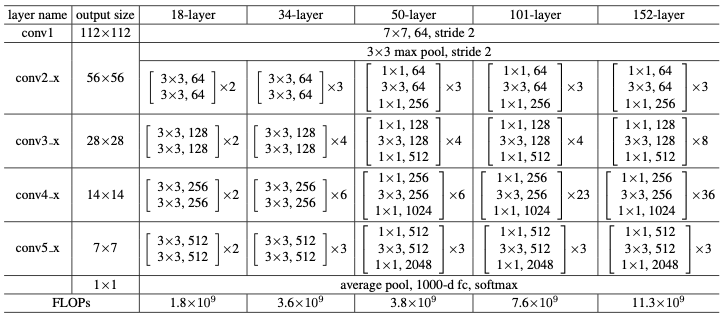

In [7]:
IPyImage('resnet_kernels_layers.png')

In [19]:
resnet_34=[("b",3,64),("r",1,128),("b",3,128),("r",1,256),("b",5,256),("r",1,512),("b",2,512)]

resnet_18=[("b",2,64),("r",1,128),("b",1,128),("r",1,256),("b",1,256),("r",1,512),("b",1,512)]

resnet_50=[("bn",3,64),("rbn",1,128),("bn",3,128),("rbn",1,256),("bn",5,256),("rbn",1,512),("bn",2,512)]

resnet_101=[("bn",3,64),("rbn",1,128),("bn",3,128),("rbn",1,256),("bn",22,256),("rbn",1,512),("bn",2,512)]

resnet_152=[("bn",3,64),("rbn",1,128),("bn",7,128),("rbn",1,256),("bn",35,256),("rbn",1,512),("bn",2,512)]

In [43]:
net=ResNet(10,size=(3,32,32),block_series=resnet_50)

Using CIFAR10 dataset


# Training

In [39]:
def get_n_params(model):
    p=0
    mem=0
    for a in model.parameters():
        p+=a.nelement()
        mem+=a.element_size()*a.nelement()
    return p, str(mem/10**6)+' MB'

In [44]:
get_n_params(net)

(38092362, '152.369448 MB')

In [45]:
data_dir="/notebooks/datasets/fastai/cifar10/"
data_train=data_dir+'train'
data_test=data_dir+'test'

In [46]:
class Cifar10Dataset(Dataset):
    def __init__(self, data_dir, data_size = 0, transforms = None):
        label_folders = os.listdir(data_dir)
        folders_path = [os.path.join(data_dir,x) for x in label_folders]
        
        files=[(os.path.join(path,x),label) for label,path in zip(label_folders,folders_path) for x in os.listdir(path)]
        
        if data_size < 0 or data_size > len(files):
            assert("Data size should be between 0 to number of files in the dataset")
        
        if data_size == 0:
                
            data_size=len(files)
        
        self.data_size = data_size
        self.files = random.sample(files, self.data_size)
        self.transforms = transforms
        self.label_mapping={label:i for i,label in enumerate(label_folders)}
        
    def __len__(self):
        return self.data_size
    
    def __getitem__(self, idx):
        image_address = self.files[idx]
        image = Image.open(image_address[0])
        image=np.array(image).astype(np.float32)
        label_name = image_address[1]
        label = self.label_mapping[label_name]
        
        if self.transforms:
            image = self.transforms(image)

        return image.transpose(2,1,0), label

In [47]:
train_data=Cifar10Dataset(data_dir+'train')

In [48]:
train_data.label_mapping

{'bird': 0,
 'dog': 1,
 'cat': 2,
 'ship': 3,
 'horse': 4,
 'automobile': 5,
 'airplane': 6,
 'frog': 7,
 'deer': 8,
 'truck': 9}

In [49]:
train_dl = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True, num_workers=6)

In [50]:
test_data=Cifar10Dataset(data_dir+'test')
test_dl=torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True, num_workers=6)

In [51]:
def train(model, train_loader, epochs, criterion, optimizer, device):
    L=len(train_loader)
    for epoch in range(1, epochs + 1):
        model.train() # Make sure that the model is in training mode.

        total_loss = 0
            
        for batch in tqdm(train_loader):
            # get data
            batch_x, batch_y = batch
            
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()

            # get predictions from model
            y_pred = model(batch_x)
        
            # perform backprop
            loss = criterion(y_pred, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.data.item()
        
        print("Epoch: {}, Loss: {}".format(epoch, total_loss / L))

In [52]:
def weight_init(obj):
    classname = obj.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.kaiming_normal_(obj.weight, mode='fan_out', nonlinearity='relu')
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(obj.weight, 1.0, 0.02)
        torch.nn.init.zeros_(obj.bias)

In [53]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [54]:
resnet=net.to(device)

In [55]:
resnet.apply(weight_init)

ResNet(
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (avg): AdaptiveAvgPool2d(output_size=(1, 1))
  (resnet_layers): Sequential(
    (0): bottleneck(
      (stack): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 256, kernel_size=(1, 1),

In [56]:
optimizer = optim.Adam(resnet.parameters(),lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [65]:
train(resnet,train_dl,5,loss_fn,optimizer,device)

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.11530828313983005


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.11113737794139501


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.10507993626853694


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.0949776582896252


100%|██████████| 391/391 [02:13<00:00,  2.94it/s]

Epoch: 5, Loss: 0.09739472692274986


In [59]:
def accuracy(model,val_dl):
  model.eval()
  with torch.no_grad():
        accu=0
        for batch in val_dl:
            val_X,val_y=batch
            val_X=val_X.to(device)
            val_y=val_y.to(device)
            x=model(val_X)
            probs=F.softmax(x,dim=1)
            preds=probs.argmax(dim=1)
            accu+=(preds==val_y).sum().item()
    
  accu=accu/len(val_dl.dataset)*100
  return accu

In [66]:
accuracy(resnet,train_dl)

97.956

In [67]:
accuracy(resnet,test_dl)

80.76